<h1>NFL Betting Project: Point Total Prediction Model</h1>

In [1]:
# author: Warren Blood
# last update: 12-5-2021

In [2]:
# import packages
import math
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

<h3>Data Import</h3>

In [3]:
# import preprocessed game data csv file
data = pd.read_csv('Preprocessed Game Data.csv', sep=',', encoding='unicode_escape')
# check for any missing values in data
print('Number of missing values in data: ' + str(sum(data.isnull().sum())))
data.head()

Number of missing values in data: 0


,indoor_stadium,divisional,AT&T Stadium,Allegiant Stadium,Arrowhead Stadium,Azteca Stadium,Bank of America Stadium,Caesars Superdome,Candlestick Park,Edward Jones Dome,...,home_margin_o_u,away_margin_o_u,home_margin_ats,away_margin_ats,point_total,vegas_over_under,hit_over,home_min_away_spread,vegas_home_min_away_spread,home_covered_spread
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,0.0,-4.0,0.0,44.0,39.0,1.0,-18.0,-6.5,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,1.0,5.0,61.0,51.0,1.0,1.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,-5.0,3.0,52.0,40.0,1.0,-32.0,-14.5,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-5.0,-1.0,3.0,-1.0,40.0,39.0,1.0,6.0,7.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,4.0,-1.0,0.0,44.0,46.5,0.0,10.0,5.5,1.0


In [4]:
# drop columns from data that contains info not available prior to kickoff to create feature space X
X = data.drop(['point_total', 'hit_over', 'home_min_away_spread', 'home_covered_spread'], axis=1)

# additionally, drop certain features, including:
#    -OHE features without sufficient presence in dataset or that are no longer relevant (i.e. retired head 
#          coaches & first-time head coaches with few examples in dataset)
#    -Overly repetitive features
X = X.drop(['Allegiant Stadium','Azteca Stadium','Candlestick Park','Edward Jones Dome','Georgia Dome',
            'Los Angeles Memorial Coliseum','Mall of America Field','Qualcomm Stadium','Ring Central Coliseum',
            'SoFi Stadium','StubHub Center','TCF Bank Stadium','Tottenham Stadium','Twickenham Stadium',
            'Wembley Stadium','home_coach Adam Gase','home_coach Anthony Lynn','home_coach Arthur Smith',
            'home_coach Ben McAdoo','home_coach Bill Callahan',"home_coach Bill O'Brien",'home_coach Brandon Staley',
            'home_coach Brian Flores','home_coach Chip Kelly','home_coach Chuck Pagano','home_coach Dan Campbell',
            'home_coach Dan Quinn','home_coach Darrell Bevell','home_coach David Culley','home_coach Dennis Allen',
            'home_coach Dirk Koetter','home_coach Doug Marrone','home_coach Doug Pederson','home_coach Freddie Kitchens',
            'home_coach Gary Kubiak','home_coach Greg Schiano','home_coach Gregg Williams','home_coach Gus Bradley',
            'home_coach Hue Jackson','home_coach Jack Del Rio','home_coach Jason Garrett','home_coach Jay Gruden',
            'home_coach Jeff Fisher','home_coach Jim Caldwell','home_coach Jim Harbaugh','home_coach Jim Schwartz',
            'home_coach Jim Tomsula','home_coach Joe Judge','home_coach Joe Philbin','home_coach John Fassel',
            'home_coach John Fox','home_coach Jon Gruden','home_coach Ken Whisenhunt','home_coach Kevin Stefanski',
            'home_coach Kliff Kingsbury','home_coach Leslie Frazier','home_coach Lovie Smith','home_coach Marc Trestman',
            'home_coach Marvin Lewis','home_coach Matt LaFleur','home_coach Matt Nagy','home_coach Matt Patricia',
            'home_coach Matt Rhule','home_coach Mike McCoy','home_coach Mike Mularkey','home_coach Mike Munchak',
            'home_coach Mike Pettine','home_coach Mike Shanahan','home_coach Mike Smith','home_coach Nick Sirianni',
            'home_coach Pat Shurmur','home_coach Perry Fewell','home_coach Raheem Morris','home_coach Rex Ryan',
            'home_coach Rob Chudzinski','home_coach Robert Saleh','home_coach Romeo Crennel','home_coach Steve Spagnuolo',
            'home_coach Steve Wilks','home_coach Todd Bowles','home_coach Tom Coughlin','home_coach Tony Sparano',
            'home_coach Urban Meyer','home_coach Vance Joseph','home_coach Vic Fangio','home_coach Wade Phillips',
            'home_coach Zac Taylor','away_coach Adam Gase','away_coach Anthony Lynn','away_coach Arthur Smith',
            'away_coach Ben McAdoo','away_coach Bill Callahan',"away_coach Bill O'Brien",'away_coach Brandon Staley',
            'away_coach Brian Flores','away_coach Chip Kelly','away_coach Chuck Pagano','away_coach Dan Campbell',
            'away_coach Dan Quinn','away_coach Darrell Bevell','away_coach David Culley','away_coach Dennis Allen',
            'away_coach Dirk Koetter','away_coach Doug Marrone','away_coach Doug Pederson','away_coach Freddie Kitchens',
            'away_coach Gary Kubiak','away_coach Greg Schiano','away_coach Gregg Williams','away_coach Gus Bradley',
            'away_coach Hue Jackson','away_coach Jack Del Rio','away_coach Jason Garrett','away_coach Jay Gruden',
            'away_coach Jeff Fisher','away_coach Jim Caldwell','away_coach Jim Harbaugh','away_coach Jim Schwartz',
            'away_coach Jim Tomsula','away_coach Joe Judge','away_coach Joe Philbin','away_coach John Fassel',
            'away_coach John Fox','away_coach Jon Gruden','away_coach Ken Whisenhunt','away_coach Kevin Stefanski',
            'away_coach Kliff Kingsbury','away_coach Leslie Frazier','away_coach Lovie Smith','away_coach Marc Trestman',
            'away_coach Marvin Lewis','away_coach Matt LaFleur','away_coach Matt Nagy','away_coach Matt Patricia',
            'away_coach Matt Rhule','away_coach Mike McCoy','away_coach Mike Mularkey','away_coach Mike Munchak',
            'away_coach Mike Pettine','away_coach Mike Shanahan','away_coach Mike Smith','away_coach Nick Sirianni',
            'away_coach Pat Shurmur','away_coach Perry Fewell','away_coach Raheem Morris','away_coach Rex Ryan',
            'away_coach Rob Chudzinski','away_coach Robert Saleh','away_coach Romeo Crennel','away_coach Steve Spagnuolo',
            'away_coach Steve Wilks','away_coach Todd Bowles','away_coach Tom Coughlin','away_coach Tony Sparano',
            'away_coach Urban Meyer','away_coach Vance Joseph','away_coach Vic Fangio','away_coach Wade Phillips',
            'away_coach Zac Taylor','home_off_rush_ypc_re','home_off_rush_ypc_rt','home_off_rush_ypc_rg','home_off_rush_ypc_c',
            'home_off_rush_ypc_lg','home_off_rush_ypc_lt','home_off_rush_ypc_le','home_def_rush_ypc_re','home_def_rush_ypc_rt',
            'home_def_rush_ypc_rg','home_def_rush_ypc_c','home_def_rush_ypc_lg','home_def_rush_ypc_lt','home_def_rush_ypc_le',
            'away_off_rush_ypc_re','away_off_rush_ypc_rt','away_off_rush_ypc_rg','away_off_rush_ypc_c','away_off_rush_ypc_lg',
            'away_off_rush_ypc_lt','away_off_rush_ypc_le','away_def_rush_ypc_re','away_def_rush_ypc_rt','away_def_rush_ypc_rg',
            'away_def_rush_ypc_c','away_def_rush_ypc_lg','away_def_rush_ypc_lt','away_def_rush_ypc_le', 'home_off_ny_a',
            'home_def_ny_a','away_off_ny_a','away_def_ny_a'], axis=1)

# target column y
y = data['hit_over']

<h3>Split Data</h3>

In [5]:
# Split data into 80/20 training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
# k-Fold validation split do perform throughout model selection
kf = KFold(n_splits=10, shuffle=True, random_state=10)

<h2>I. Ridge Classifier</h2>

In [7]:
# Ridge Classifier Hyperparameters Tuned:
# - alpha: Constant multiplied by regularization term (regularization strength)

In [8]:
ridge = RidgeClassifierCV(alphas=[0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50], scoring='balanced_accuracy', cv=kf)

selector = RFECV(estimator=ridge, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('select', selector)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('select',
                 RFECV(cv=KFold(n_splits=10, random_state=10, shuffle=True),
                       estimator=RidgeClassifierCV(alphas=array([ 0.05,  0.1 ,  0.5 ,  1.  ,  2.  ,  5.  , 10.  , 20.  , 50.  ]),
                                                   cv=KFold(n_splits=10, random_state=10, shuffle=True),
                                                   scoring='balanced_accuracy'),
                       n_jobs=-1, scoring='balanced_accuracy'))])

In [9]:
feat_names = []
for i in range(len(selector.ranking_)):
    if(selector.ranking_[i]==1):
        feat_names.append(X_train.columns[i])

In [14]:
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
              'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

In [15]:
FS_x_train = X_train[feat_names]

In [27]:
ridge = RidgeClassifierCV(alphas=np.arange(0.5,101,0.5), scoring='balanced_accuracy', cv=kf, 
                         class_weight='balanced')

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('classify', ridge)])

pipeline.fit(FS_x_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classify',
                 RidgeClassifierCV(alphas=array([  0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,
         5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,
         9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,
        14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,
        18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,  22.5,
        23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,  27. ,
        27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,  31....
        72.5,  73. ,  73.5,  74. ,  74.5,  75. ,  75.5,  76. ,  76.5,
        77. ,  77.5,  78. ,  78.5,  79. ,  79.5,  80. ,  80.5,  81. ,
        81.5,  82. ,  82.5,  83. ,  83.5,  84. ,  84.5,  85. ,  85.5,
        86. ,  86.5,  87. ,  87.5,  88. ,  88.5,  89. ,  89.5,  90. ,
        90.5,  91. ,  91.5,  92. ,  92.5,  93. ,  93.5,  94. ,  94.5,
        95. ,  95.5,  96. ,  96.5,  97. ,  

In [28]:
ridge.alpha_

0.5

In [29]:
ridge.best_score_

0.5845653123023907

**Best k-Fold CV Bal. Acc.:** 0.5845653123023907

**Feature Scale Function:** StandardScaler()

**Features Selected:** ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
             'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']
              
**Hyperparameters:** alpha=0.5

<h2>Model 2: Neural Network</h2>

In [31]:
# Neural Network Regressor Hyperparameters Tuned:
# - hidden_layer_sizes: (tuple) ith element represents the number of neurons in the ith hidden layer
# - activation: Activation function for the hidden layer
# - alpha: L2 penalty parameter

In [32]:
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
              'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

In [37]:
FS_x_train = X_train[feat_names]

nn = MLPClassifier(hidden_layer_sizes=(175,), activation='logistic', alpha=0.005, max_iter=1000, random_state=10)

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('classify', nn)])

search_space = [{'classify__hidden_layer_sizes': [(15,),(25,),(35,),(45,),(55,),(65,),(75,),(85,),(95,),(125,),(150,),(175,),
                                                  (200,),(45,25),(65,25),(85,25),(65,45),(85,45),(85,65),(150,25),(125,45),
                                                  (65,35,15)]},
                {'classify__activation': ['identity', 'logistic', 'tanh', 'relu']},
                {'classify__alpha': [0.00005, 0.0005, 0.005, 0.05, 0.5]}]

search = GridSearchCV(pipeline, search_space, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

search.fit(FS_x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('classify',
                                        MLPClassifier(activation='logistic',
                                                      alpha=0.005,
                                                      hidden_layer_sizes=(175,),
                                                      max_iter=1000,
                                                      random_state=10))]),
             n_jobs=-1,
             param_grid=[{'classify__hidden_layer_sizes': [(15,), (25,), (35,),
                                                           (45,), (55,), (65,),
                                                           (75,), (85,), (95,),
                                                           (125,), (150,),
                                                           (175,), (200,),
                              

In [38]:
search.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('classify',
                 MLPClassifier(activation='logistic', alpha=0.05,
                               hidden_layer_sizes=(175,), max_iter=1000,
                               random_state=10))])

In [39]:
search.best_score_

0.5870906400884808

In [53]:
# second level of parameter tuning
FS_x_train = X_train[feat_names]

nn = MLPClassifier(hidden_layer_sizes=(175,), activation='logistic', alpha=0.05, max_iter=1000, random_state=10)

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('classify', nn)])

search_space = [{'classify__hidden_layer_sizes': [(168,),(169,),(170,),(171,),(172,),(173,),(174,),(175,),(176,),(177,)]}]

search = GridSearchCV(pipeline, search_space, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

search.fit(FS_x_train, y_train)

search.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('classify',
                 MLPClassifier(activation='logistic', alpha=0.05,
                               hidden_layer_sizes=(171,), max_iter=1000,
                               random_state=10))])

In [54]:
search.best_score_

0.5875046792015322

**Best k-Fold CV Bal. Acc.:** 0.5875046792015322

**Feature Scale Function:** StandardScaler()

**Features Selected:**  ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
             'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

**Hyperparameters:** hidden_layer_sizes=(171,), activation='logistic', alpha=0.05, max_iter=1000

<h2>Final Classification Model</h2>

In [7]:
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
              'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

In [8]:
scaler = StandardScaler()

model = MLPClassifier(hidden_layer_sizes=(171,), activation='logistic', alpha=0.05, max_iter=1000, random_state=10)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

scaler.fit(FS_x_train)
x_trn = scaler.transform(FS_x_train)
x_tst = scaler.transform(FS_x_test)

model.fit(x_trn, y_train)
train_pred_values = model.predict(x_trn)
test_pred_values = model.predict(x_tst)

train_acc = balanced_accuracy_score(np.ravel(y_train), train_pred_values)
test_acc = balanced_accuracy_score(np.ravel(y_test), test_pred_values)

print('Training Set Balanced Accuracy: ' + str(train_acc))
print('Test Set Balanced Accuracy: ' + str(test_acc))

Training Set Balanced Accuracy: 0.6038920095852054
Test Set Balanced Accuracy: 0.5448057097541634


<h2>Model Simulation (256 Games)</h2>

In [113]:
# number of simulations to run
num_simulations = 100

# starting bankroll ($)
starting_bankroll = 10000

# size of each bet (as fraction of bankroll)
bet_size_frac = 0.05

# number of bets after which bet sizes are updated (to bet_size_frac)
n_update = 10

In [114]:
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
              'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

Starting Bankroll: $10000
Avg Ending Bankroll: $14771.45
Bet Win %: 0.5478
Min Ending Bankroll: $5113.24
Max Ending Bankroll: $42768.2
Avg Bet Size: $628.72
% Exceeded 4x (Above $40,000): 1
Ending Bankrolls: [13442.53, 12800.66, 11462.95, 6832.94, 30516.75, 10761.61, 14095.02, 13957.32, 25430.36, 12440.18, 12815.64, 16484.97, 24132.29, 6608.97, 11176.92, 42768.2, 16992.69, 9562.92, 16798.29, 20565.94, 6825.65, 13518.79, 32753.39, 11774.18, 12240.12, 13969.26, 14639.54, 13866.51, 11469.42, 23470.28, 10979.0, 19459.17, 9386.89, 10409.14, 10451.77, 5780.33, 18277.66, 25910.06, 14905.09, 17374.83, 7203.57, 18577.64, 12610.69, 20554.14, 16131.8, 11414.88, 8101.87, 17632.2, 5532.28, 27289.31, 13965.46, 13704.93, 13174.1, 11877.15, 10063.78, 5573.77, 15409.25, 6202.7, 13406.09, 12036.83, 14973.0, 14981.4, 9702.11, 10914.15, 9005.22, 5113.24, 29896.87, 15592.98, 13142.3, 22617.82, 5749.83, 9550.49, 16440.52, 7689.09, 5760.06, 7387.29, 36246.98, 13641.23, 20709.94, 21839.85, 14034.34, 22864.28,

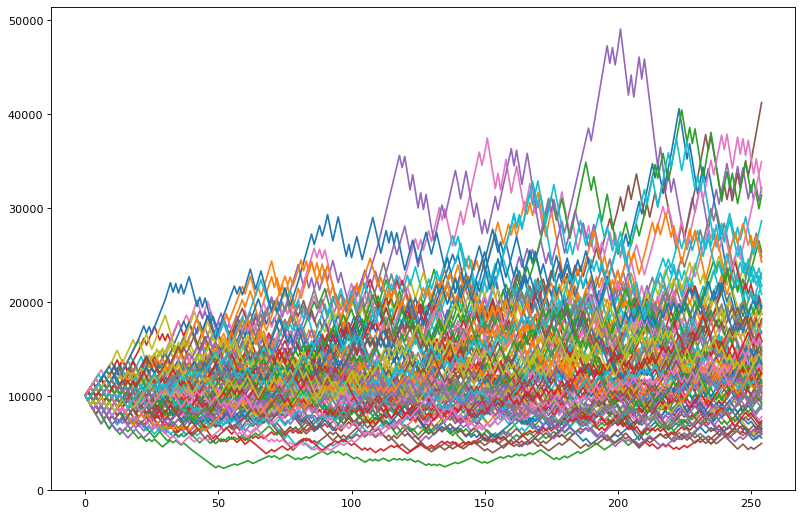

In [115]:
plt.figure(figsize=(12, 8), dpi=80)

ending_bankrolls = []
all_bet_results = []
all_bet_sizes = []
exceeded_4x = []

scaler = StandardScaler()
model = MLPClassifier(hidden_layer_sizes=(171,), activation='logistic', alpha=0.05, max_iter=1000, random_state=10)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

scaler.fit(FS_x_train)
x_trn = scaler.transform(FS_x_train)
x_tst = scaler.transform(FS_x_test)
    
model.fit(x_trn, y_train)
    
pred = model.predict(x_tst)
actual = np.ravel(y_test)

for n in range(num_simulations):
    
    actual_s, pred_s = shuffle(actual, pred)
    
    i = -1
    bankroll = starting_bankroll
    bet_size = round(bankroll*bet_size_frac, 2)

    bet_ind = []
    bankroll_lst = []
    
    stop = False
    while((i+1 < 255) and (stop == False)):
        i += 1
        bet_ind.append(i)
        bankroll_lst.append(bankroll)
        all_bet_sizes.append(bet_size)

        if(pred_s[i] == actual_s[i]):
            winnings = round(bet_size*0.909091, 2)
            bankroll += winnings
            all_bet_results.append(1)
        else:
            bankroll -= bet_size
            all_bet_results.append(0)
        
        bankroll = round(bankroll, 2)

        if((i+1) % n_update == 0):
            bet_size = round(bankroll*bet_size_frac, 2)

        if((bankroll<= bet_size)):
            stop = True
    
    ending_bankrolls.append(bankroll)
    
    if(bankroll > 4*starting_bankroll):
        exceeded_4x.append(1)
    
    plt.plot(bet_ind, bankroll_lst)

print('Starting Bankroll: $' + str(starting_bankroll))
print('Avg Ending Bankroll: $' + str(round(sum(ending_bankrolls)/len(ending_bankrolls), 2)))
print('Bet Win %: ' + str(round(sum(all_bet_results) / len(all_bet_results), 4)))
print('Min Ending Bankroll: $' + str(min(ending_bankrolls)))
print('Max Ending Bankroll: $' + str(max(ending_bankrolls)))
print('Avg Bet Size: $' + str(round(sum(all_bet_sizes) / len(all_bet_sizes), 2)))
print('% Exceeded 4x (Above $40,000): ' + str(sum(exceeded_4x)))
print('Ending Bankrolls: ' + str(ending_bankrolls))

<h2>III. Identifying High Value Bets Using Logistic Regression</h2>

In [68]:
# Logistic Regression Hyperparameters Tuned:
# - C: Regularization parameter (positive)

In [69]:
modelCV = LogisticRegressionCV(cv=kf, scoring='neg_log_loss', max_iter=1000, n_jobs=-1, random_state=10)

selector = RFECV(estimator=modelCV, step=1, cv=kf, scoring='neg_log_loss', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('selector', selector)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('selector',
                 RFECV(cv=KFold(n_splits=10, random_state=10, shuffle=True),
                       estimator=LogisticRegressionCV(cv=KFold(n_splits=10, random_state=10, shuffle=True),
                                                      max_iter=1000, n_jobs=-1,
                                                      random_state=10,
                                                      scoring='neg_log_loss'),
                       n_jobs=-1, scoring='neg_log_loss'))])

In [70]:
feat_names = []
for i in range(len(selector.ranking_)):
    if(selector.ranking_[i]==1):
        feat_names.append(X_train.columns[i])

In [75]:
feat_names = ['indoor_stadium','divisional','AT&T Stadium','Arrowhead Stadium','Bank of America Stadium','Caesars Superdome',
              'Empower Field at Mile High','Ford Field','Gillette Stadium','Hard Rock Stadium','Heinz Field','Highmark Stadium',
              "Levi's Stadium",'Lincoln Financial Field','Lucas Oil Stadium','M&T Bank Stadium','MetLife Stadium','NRG Stadium',
              'Nissan Stadium','Soldier Field','U.S. Bank Stadium','temp','wind_speed','home_coach Andy Reid',
              'home_coach Bill Belichick','home_coach Bruce Arians','home_coach Kyle Shanahan','home_coach Mike McCarthy',
              'home_coach Mike Tomlin','home_coach Mike Vrabel','home_coach Mike Zimmer','home_coach Sean McDermott',
              'home_coach Sean McVay','home_coach Sean Payton','away_coach Andy Reid','away_coach Bill Belichick',
              'away_coach Bruce Arians','away_coach Frank Reich','away_coach John Harbaugh','away_coach Mike McCarthy',
              'away_coach Mike Tomlin','away_coach Mike Vrabel','away_coach Mike Zimmer','away_coach Pete Carroll',
              'away_coach Ron Rivera','away_coach Sean McDermott','home_rest_days','away_rest_days','home_PAT','home_FG_39',
              'home_FG_49','away_FG_49','home_FG_50','away_yds_per_punt','home_punts_in_20','home_off_pen_yds',
              'away_off_pen_yds','home_def_pen_yds','away_def_pen_yds','home_off_rush_ypc','home_def_rush_ypc',
              'away_def_rush_ypc','home_off_any_a','away_def_any_a','away_off_epr','away_def_epr','home_off_edps',
              'away_off_edps','home_def_edps','away_def_edps','home_off_edrs','home_def_edrs','home_fumbles_lost',
              'away_fumbles_lost','home_fumbles_taken','home_def_int_rate','away_def_int_rate','home_off_yppr','home_def_yppr',
              'home_off_ypkr','home_def_ypkr','away_def_ypkr','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr',
              'home_def_spcr','away_def_spcr','home_off_dpcr','home_def_dpcr','away_def_dpcr','home_def_tdcr','away_def_tdcr',
              'home_off_fdcr','away_off_fdcr','away_def_fdcr','home_off_rze','away_off_rze','home_def_rze','away_def_rze',
              'home_def_pts_100','away_lw_tom','home_margin_o_u','away_margin_o_u','away_margin_ats']

In [86]:
# from ridge RFECV
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc',
              'away_off_epr','away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr',
              'home_def_rze','away_def_rze','away_def_pts_100','home_margin_o_u']

In [87]:
FS_x_train = X_train[feat_names]

In [88]:
logistic = LogisticRegression(penalty='l2', C=0.1, random_state=10, max_iter=1000, n_jobs=-1)

pipeline = Pipeline(steps=[('scale', StandardScaler()), ('classify', logistic)])

search_space = [{'classify__C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]}]

search = GridSearchCV(pipeline, search_space, scoring='neg_log_loss', n_jobs=-1, cv=kf)

search.fit(FS_x_train, y_train)

search.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('classify',
                 LogisticRegression(C=0.02, max_iter=1000, n_jobs=-1,
                                    random_state=10))])

In [89]:
search.best_score_

-0.6741898710681858

In [90]:
# final logistic model
logistic = LogisticRegression(penalty='l2', C=0.02, random_state=10, max_iter=1000, n_jobs=-1)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

scaler.fit(FS_x_train)
x_trn = scaler.transform(FS_x_train)
x_tst = scaler.transform(FS_x_test)

model.fit(x_trn, y_train)
tst_probs = model.predict_proba(x_tst)

In [120]:
bets=[]
for i in range(len(tst_probs)):
    if(tst_probs[i][1] > 0.55):
        if(np.ravel(y_test)[i] == 1):
            bets.append(1)
        else:
            bets.append(0)
    elif(tst_probs[i][1] < 0.45):
        if(np.ravel(y_test)[i] == 1):
            bets.append(0)
        else:
            bets.append(1)
print('Bets Placed: ' + str(sum(bets)))
sum(bets)/len(bets)

Bets Placed: 144


0.5217391304347826

In [103]:
y_40 = []
y_40_45 = []
y_45_50 = []
y_50_55 = []
y_55_60 = []
y_60 = []

for i in range(len(tst_probs)):
    if((tst_probs[i][1] < 0.40)):
        y_40.append(np.ravel(y_test)[i])
    elif((tst_probs[i][1] >= 0.40) and (tst_probs[i][1] < 0.45)):
        y_40_45.append(np.ravel(y_test)[i])
    elif((tst_probs[i][1] >= 0.45) and (tst_probs[i][1] < 0.50)):
        y_45_50.append(np.ravel(y_test)[i])
    elif((tst_probs[i][1] >= 0.50) and (tst_probs[i][1] < 0.55)):
        y_50_55.append(np.ravel(y_test)[i])
    elif((tst_probs[i][1] >= 0.55) and (tst_probs[i][1] < 0.60)):
        y_55_60.append(np.ravel(y_test)[i])
    elif((tst_probs[i][1] >= 0.60)):
        y_60.append(np.ravel(y_test)[i])

In [104]:
p_40 = sum(y_40) / len(y_40)
p_40_45 = sum(y_40_45) / len(y_40_45)
p_45_50 = sum(y_45_50) / len(y_45_50)
p_50_55 = sum(y_50_55) / len(y_50_55)
p_55_60 = sum(y_55_60) / len(y_55_60)
p_60 = sum(y_60) / len(y_60)

In [105]:
p_60

0.5357142857142857

<h2>Logistic Model Simulation</h2>

In [106]:
# number of simulations to run
num_simulations = 100

# starting bankroll ($)
starting_bankroll = 10000

# size of each bet (as fraction of bankroll)
bet_size_frac = 0.05

# number of bets after which bet sizes are updated (to bet_size_frac)
n_update = 10

In [122]:
feat_names = ['divisional','Caesars Superdome',"Levi's Stadium",'Lucas Oil Stadium','Soldier Field','wind_speed',
              'home_coach Frank Reich','home_coach Kyle Shanahan','home_coach Mike Vrabel','away_coach Andy Reid',
              'away_coach John Harbaugh','away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Mike Vrabel',
              'home_punts_in_20','home_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','away_off_epr','away_def_epr',
              'home_off_edps','away_off_edps','away_def_edps','home_def_edrs','away_fumbles_lost','home_def_int_rate',
              'home_off_ypkr','away_off_avg_sfp','home_def_spcr','away_def_dpcr','away_off_fdcr','home_def_rze','away_def_rze',
              'away_def_pts_100','home_margin_o_u']

Starting Bankroll: $10000
Avg Ending Bankroll: $9015.73
Avg Bets Placed: 94.14
Bet Win %: 0.5113
Min Ending Bankroll: $2013.74
Max Ending Bankroll: $28245.3
Avg Bet Size: $464.08
% Exceeded 4x (Above $40,000): 0


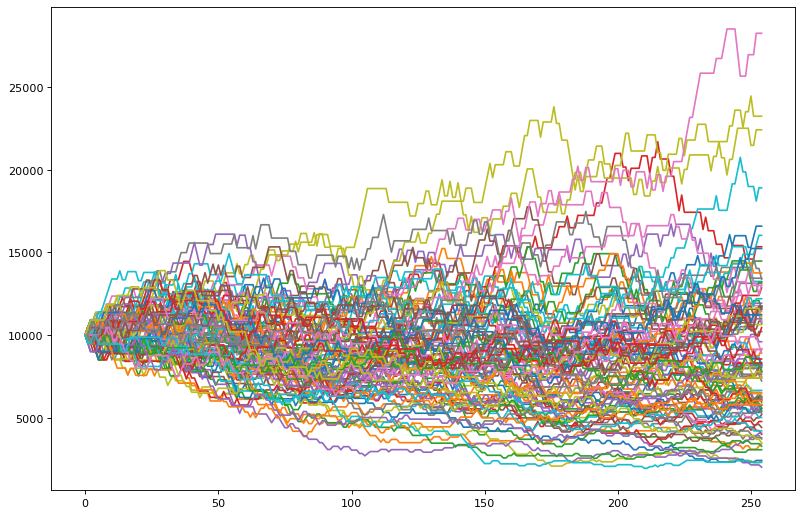

In [123]:
plt.figure(figsize=(12, 8), dpi=80)

ending_bankrolls = []
all_bet_results = []
all_bet_sizes = []
exceeded_4x = []

scaler = StandardScaler()
model = logistic=LogisticRegression(penalty='l2', C=0.002, random_state=10, max_iter=1000, n_jobs=-1)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

scaler.fit(FS_x_train)
x_trn = scaler.transform(FS_x_train)
x_tst = scaler.transform(FS_x_test)
    
model.fit(x_trn, y_train)
    
pred = model.predict_proba(x_tst)
actual = np.ravel(y_test)

for n in range(num_simulations):
    
    actual_s, pred_s = shuffle(actual, pred)
    
    i = -1
    bankroll = starting_bankroll
    bet_size = round(bankroll*bet_size_frac, 2)

    ind = []
    bankroll_lst = []
    
    stop = False
    while((i+1 < 255) and (stop == False)):
        i += 1
        ind.append(i)
        bankroll_lst.append(bankroll)
        
        if(pred_s[i][1] > 0.55):
            all_bet_sizes.append(bet_size)
            if(actual[i]==1):
                winnings = round(bet_size*0.909091, 2)
                bankroll += winnings
                all_bet_results.append(1)
            else:
                bankroll -= bet_size
                all_bet_results.append(0)
            bankroll = round(bankroll, 2)
        elif(pred_s[i][1] < 0.45):
            all_bet_sizes.append(bet_size)
            if(actual[i]==0):
                winnings = round(bet_size*0.909091, 2)
                bankroll += winnings
                all_bet_results.append(1)
            else:
                bankroll -= bet_size
                all_bet_results.append(0)
            bankroll = round(bankroll, 2)

        if((len(all_bet_results)+1) % n_update == 0):
            bet_size = round(bankroll*bet_size_frac, 2)

        if(bankroll<= bet_size):
            stop = True
    
    ending_bankrolls.append(bankroll)
    
    if(bankroll > 4*starting_bankroll):
        exceeded_4x.append(1)
    
    plt.plot(ind, bankroll_lst)

print('Starting Bankroll: $' + str(starting_bankroll))
print('Avg Ending Bankroll: $' + str(round(sum(ending_bankrolls)/len(ending_bankrolls), 2)))
print('Avg Bets Placed: ' + str(round(len(all_bet_results)/num_simulations, 2)))
print('Bet Win %: ' + str(round(sum(all_bet_results) / len(all_bet_results), 4)))
print('Min Ending Bankroll: $' + str(min(ending_bankrolls)))
print('Max Ending Bankroll: $' + str(max(ending_bankrolls)))
print('Avg Bet Size: $' + str(round(sum(all_bet_sizes) / len(all_bet_sizes), 2)))
print('% Exceeded 4x (Above $40,000): ' + str(sum(exceeded_4x)))